In [1]:
import numpy as np
from traj_opt import TrajOpt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
#from single_pendulum_task import single_pendulum_task as Task
from double_pendulum_task import double_pendulum_task as Task

%load_ext autoreload
%autoreload 2

In [2]:
task = Task()

### Basis functions. Providing Phi_T, Rw

OBF

In [3]:
to = TrajOpt(task.ndof)

### Sequential least-squares quadratic programming

In [4]:
def fun(p):
    w = np.concatenate((task.q_0, p, task.q_d, np.zeros(2*task.ndof)))
    return task.alpha_control * task.control_cost(w)

def torque_con_p(p):
    w = np.concatenate((task.q_0, p, task.q_d, np.zeros(2*task.ndof)))
    return task.inverse_dynamics(w).flatten('F')

In [5]:
def run_opt(num_basis):
    nw = num_basis + 4
    num_via = num_basis + 1
    h = task.T * np.ones(num_via) / num_via
    to.setup_task(h)

    Phi = to.get_Phi(task.t_cost_array)
    dPhi = to.get_dPhi(task.t_cost_array)
    ddPhi = to.get_ddPhi(task.t_cost_array)

    task.set_basis(Phi, dPhi, ddPhi)

    Xi = np.zeros((nw*task.ndof, num_basis*task.ndof))
    Xi[task.ndof:-3*task.ndof] = np.eye(num_basis*task.ndof)

    def grad(p):
        w = np.concatenate((task.q_0, p, task.q_d, np.zeros(2*task.ndof)))
        return (task.alpha_control * task.control_grad(w)) @ Xi

    K = len(task.t_cost_array)
    
    q_min = np.zeros(task.ndof*num_basis)
    q_max = np.zeros(task.ndof*num_basis)
    tau_lim = np.zeros(task.ndof*K)
    for i in range(task.ndof):
        q_min[i::task.ndof] = task.q_min[i] * np.ones(num_basis)
        q_max[i::task.ndof] = task.q_max[i] * np.ones(num_basis)
        tau_lim[i*K:(i+1)*K] = task.tau_lim[i] * np.ones(K)

    constraints = []
    constraints.append(LinearConstraint(np.eye(num_basis*task.ndof), q_min, q_max))
    constraints.append(NonlinearConstraint(torque_con_p, -tau_lim, tau_lim))

    p_init = np.zeros(num_basis*task.ndof)
    for i in range(num_basis):
        p_init[i*task.ndof:(i+1)*task.ndof] = task.q_0 + np.random.normal(0, 0, task.ndof)

    start = time.time()
    res = minimize(fun, p_init, method='SLSQP', jac=grad, bounds=None, constraints=constraints, options={'maxiter': 1000, 'ftol': 1e-6, 'disp': False})
    duration = time.time()-start
    print("Elapsed time: ", duration," [s]")
    return res.success, res.fun, np.concatenate((task.q_0, res.x, task.q_d, np.zeros(2*task.ndof))), duration

In [6]:
success = False
num_basis = 1
beta = 1.5
T = 0
while not success and num_basis < 200:
    print(num_basis)
    success, f, w_opt, duration = run_opt(num_basis)
    num_basis = int(np.ceil(num_basis*beta))
    T += duration

print(success, f, T)

1
Elapsed time:  0.013083219528198242  [s]
2
Elapsed time:  0.4662818908691406  [s]
3
Elapsed time:  0.5451633930206299  [s]
5
Elapsed time:  0.17466998100280762  [s]
8
Elapsed time:  1.7276849746704102  [s]
12
Elapsed time:  3.7220630645751953  [s]
18
Elapsed time:  1.2765161991119385  [s]
27
Elapsed time:  16.164079904556274  [s]
True 1.8300670673869806 24.089542627334595


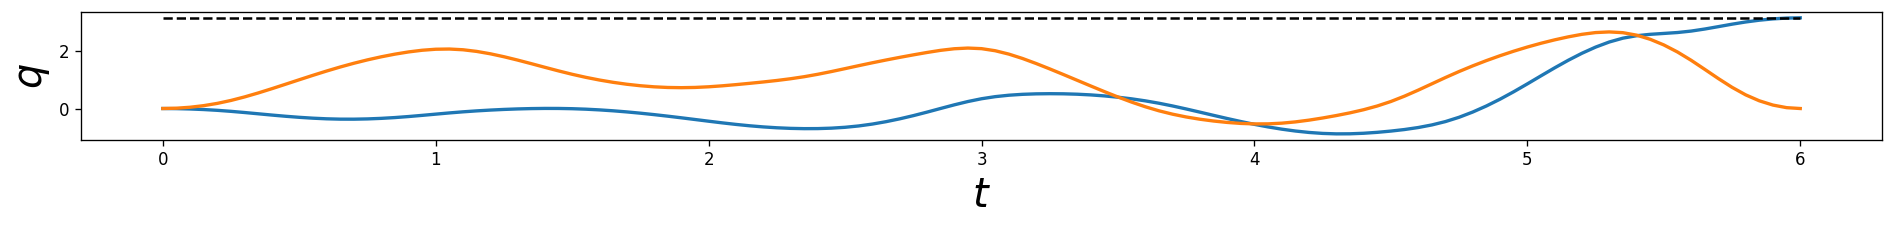

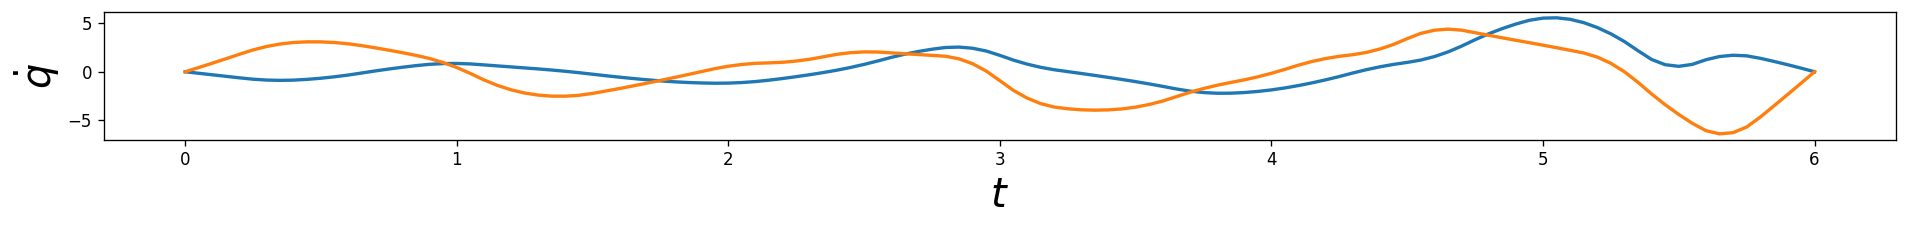

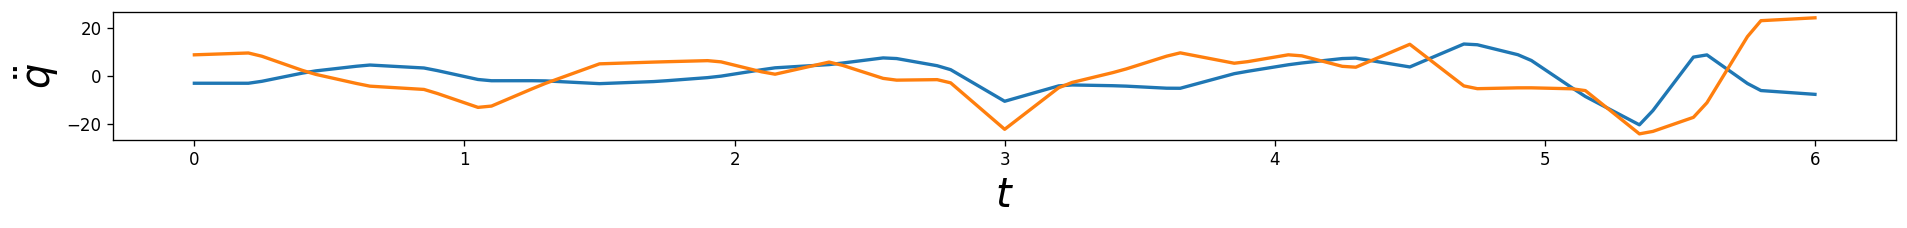

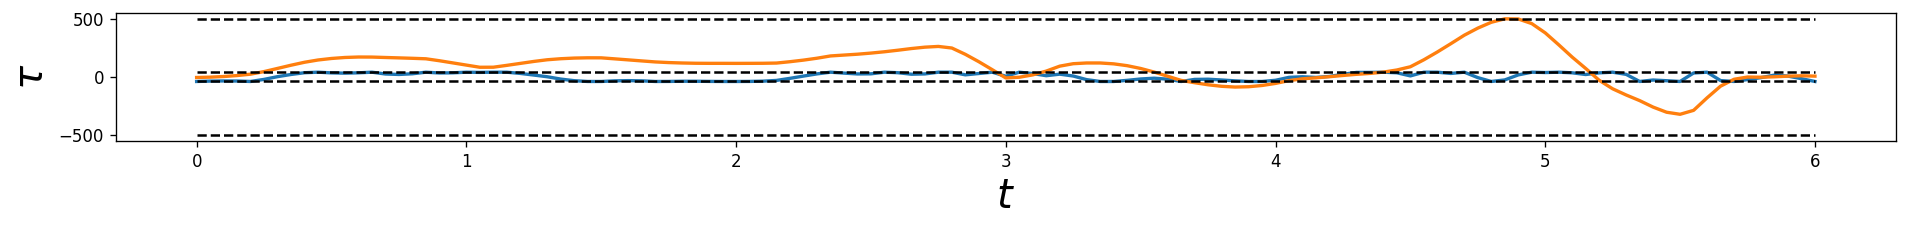

In [7]:
task.plot_q(w_opt)
task.plot_dq(w_opt)
task.plot_ddq(w_opt)
task.plot_tau(w_opt)

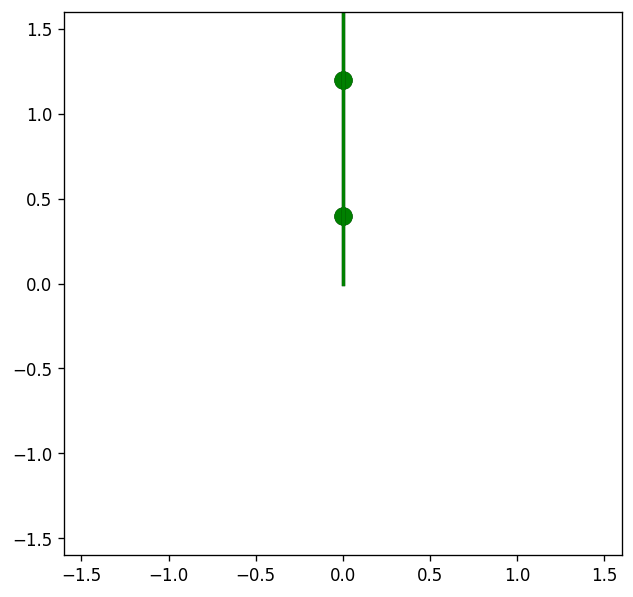

In [9]:
#task.save_animation(w_opt)